## In this Colab we:
1. import list of latin names (ex. emma, justin etc.)
2. prepare & encode data
    - 'emma' : [e  m  m] -> [a]
    - tensor : [5 13 13] -> [1]
    - split train-dev-test
3. initialize trainable embedding matrix C.shape = [vocab_size(27) , **EMB_SIZE** (2)]
    - map any of 27 letter encodings to its embedding. ex. [0] -> [0.14, 2.14, -1.65, 0.76]
4. Initialize trainable architecture:
    - z = emb @ hidden_W + hidden_b
        - z = BatchNorm(z)?
    - h = tanh(z)
    - logits = h @ out_W + out_b
    - F.cross_entropy(logits, Y_true)
5. train for **N_EPOCHS**
6. Compute train & dev loss. Vizualize it

## Result:
1. vizualize smart initialization improvements:
    - 0.1 * hidden_W
    - 0.01 * out_W
2. vizualize motivation for 1/sqrt(N) normalization
3. introduce **BatchNorm** and discuss its keypoints

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

BATCH_NORM = False


In [2]:
words = open('../docs/names.txt', 'r').read().splitlines()
print(f'{len(words)=}')
words[:7]

len(words)=32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia']

In [3]:
# build vocab + vLook-Up tables
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(chars + ['.'])

In [4]:
WINDOW = 3          # how many previous element to consider

# BUILD DATA given WINDOW size

# example 'emma', WINDOW == 3
# context -> output  |  torch.tensor:
#  [...]  -> 'e'     |  [ 0, 0, 0] -> [5]
#  [..e]  -> 'm'     |  [ 0, 0, 5] -> [13]
#  [.em]  -> 'm'     |  [ 0, 5,13] -> [13]
#  [emm]  -> 'a'     |  [ 5,13,13] -> [1]
#  [mma]  -> '.'     |  [13,13, 1] -> [0]


X, Y = [], []

for w in words:

    context = [0] * WINDOW
    for ch in w + '.' :
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        context = context[1:] + [ix] # update context

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'Example X[0]: \n{X[0]} -> {Y[0]}\n')
print(f'{ X_train.shape=} \n{ y_train.shape=}')
print(f'{ y_dev.shape=} \n{ y_test.shape=}')

Example X[0]: 
tensor([0, 0, 0]) -> 5

 X_train.shape=torch.Size([184797, 3]) 
 y_train.shape=torch.Size([184797])
 y_dev.shape=torch.Size([20534]) 
 y_test.shape=torch.Size([22815])


### Create simple Embeddings & Neural Network

In [5]:
EMB_SIZE = 10        # dimention of embedding space
HIDDEN_SIZE = 200   # size of hidden layer

g = torch.Generator().manual_seed(2147483647)
parameters = []

# BUILD EMBEDDINGS (aka vlook-up)
C = torch.randn((vocab_size,EMB_SIZE),                  generator=g) # untrained
parameters.append(C)

# BUILD HIDDEN LAYER
hidden_W = torch.randn((WINDOW*EMB_SIZE, HIDDEN_SIZE),  generator=g) # untrained
parameters.append(hidden_W)

if not BATCH_NORM:
    hidden_b = torch.randn(HIDDEN_SIZE,                 generator=g) # non-sense if Batch Norm
    parameters.append(hidden_b)

# BUILD OUT LAYER
out_W = torch.randn((HIDDEN_SIZE, vocab_size),          generator=g) # untrained
out_b = torch.randn(vocab_size,                         generator=g) # untrained
parameters.extend([out_W, out_b])

# stable initialization 
init_const = (WINDOW*EMB_SIZE)**0.5 # aka sqrt(N)
out_const = 0.01

hidden_W /= init_const # avoid "dead" hidden activation (-> zero gradients)
out_W    *= out_const # avoid over-confident mis-prediction (-> bad initial weights and loss)
out_b    *= 0.0        # same

# batch normalization (stretch and shift the resulting N(0,1) )
if BATCH_NORM:
    bn_gain = torch.ones((1, HIDDEN_SIZE))                         # untrained
    bn_bias = torch.zeros((1, HIDDEN_SIZE))                        # untrained (took the role of linear bias)
    parameters.extend([bn_gain, bn_bias])

    bn_mean = torch.zeros((1, HIDDEN_SIZE))                        # non-trainable (data-dependent)
    bn_std  = torch.ones((1, HIDDEN_SIZE))                         # non-trainable (data-dependent)

for p in parameters:
    p.requires_grad = True

print('Total number of parameters:')
sum(p.nelement() for p in parameters)

Total number of parameters:


11897

In [6]:
# training params
LR = 0.1
N_EPOCHS = 200000
BATCH_SIZE = 32

loglossi = []
_show_plots = True

for epoch in range(N_EPOCHS):

    # -------- Forward-pass ---------------

    # mini batch
    ixs = torch.randint(0, X_train.shape[0], (BATCH_SIZE,),generator=g)

    # train embeddings
    emb = C[X_train[ixs]]                           # (batch, window, emb) ex. (32, 3, 10)
    emb = emb.view(-1, WINDOW*EMB_SIZE)             #  (batch, window*emb) ex. (32, 30)

    # train Hidden Layer
    #---1. sum func
    z = emb @ hidden_W                              # (batch, hidden_dim) ex. (32, 200)
    #---2. batch norm
    if BATCH_NORM:
        batch_mean = z.mean(0, keepdim=True)  #batch mean   # (1, hudden_dim)     ex. (1, 200)
        batch_std = z.std(0, keepdim=True)    # batch std   # (1, hidden_dim)     ex. (1, 200)

        z = bn_gain * (z - batch_mean) / batch_std + bn_bias    # (batch, window*emb) ex. (32, 30)
        with torch.no_grad(): # update running batch-norm mean & std (for inference)
            bn_mean = 0.999 * bn_mean + 0.001 * batch_mean
            bn_std  = 0.999 * bn_std  + 0.001 * batch_std
    else:
        z += hidden_b

    #---3. non-linearity                            # (batch, window*emb) ex. (32, 30)
    h = torch.tanh(z)

    # train Output Layer
    logits = h @ out_W + out_b                      # (batch, out_dim) ex. (32, 27)

    # compute the loss
    loss = F.cross_entropy(logits, y_train[ixs])

    if _show_plots:
        with torch.no_grad():

            z_tgt = z.view(-1).tolist()
            h_tgt = h.view(-1).tolist()
            loss0_tgt = loss.item()

            _h_ref = torch.tanh(emb @ hidden_W * init_const + hidden_b * init_const)
            h_ref = _h_ref.view(-1).tolist()

            logits_ref= _h_ref @ out_W / out_const + out_b
            loss0_ref = F.cross_entropy(logits_ref, y_train[ixs]).item()
        _show_plots = False
    
    # training
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = LR if epoch < N_EPOCHS//2 else 0.1 * LR
    for p in parameters:
        p.data += -lr * p.grad
    
    # track proress
    if epoch % 10000 == 0:
        print(f'{epoch=}/{N_EPOCHS} : {loss.item():.4f}')
    loglossi.append(loss.log10().item())
    

epoch=0/200000 : 3.3289
epoch=10000/200000 : 2.1459
epoch=20000/200000 : 2.0706
epoch=30000/200000 : 2.4067
epoch=40000/200000 : 1.9989
epoch=50000/200000 : 2.6799
epoch=60000/200000 : 2.5254
epoch=70000/200000 : 1.9959
epoch=80000/200000 : 2.2300
epoch=90000/200000 : 1.9141
epoch=100000/200000 : 2.1697
epoch=110000/200000 : 1.7450
epoch=120000/200000 : 2.0562
epoch=130000/200000 : 1.7983
epoch=140000/200000 : 2.1846
epoch=150000/200000 : 2.0751
epoch=160000/200000 : 2.3464
epoch=170000/200000 : 2.0112
epoch=180000/200000 : 2.0550
epoch=190000/200000 : 2.0820


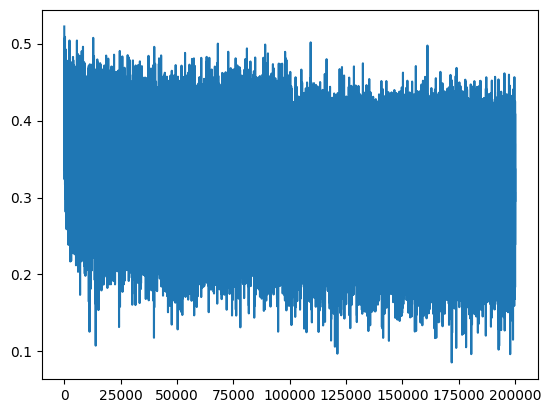

In [7]:
plt.plot(loglossi)

## Improvement N.1 :
**Dead hidden activation -> SLOW initial learning**

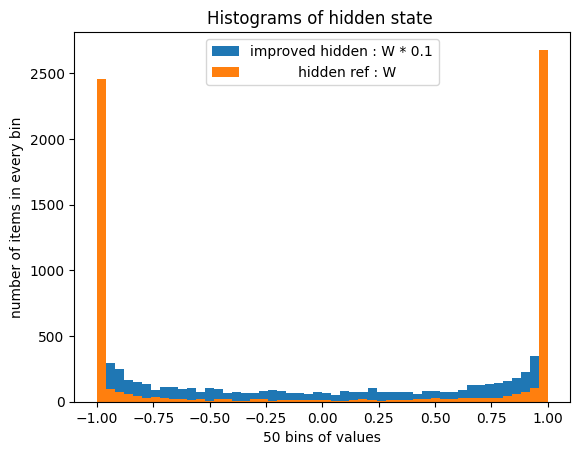

In [8]:
plt.hist(h_tgt, 50, label='improved hidden : W * 0.1')
plt.hist(h_ref, 50, label='           hidden ref : W')
# plt.hist(z_tgt, 50, label='sum func z')
plt.title('Histograms of hidden state ')
plt.xlabel('50 bins of values')
plt.ylabel('number of items in every bin')
plt.legend()

## Improvement N.2 :
**Over-condifent mis-prediction -> HIGH initial loss**

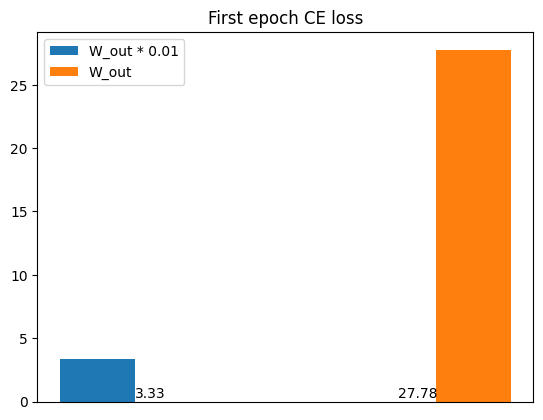

In [9]:
plt.bar(0, loss0_tgt, width=0.2, label='W_out * 0.01')
plt.text(0.1, 0.3, round(loss0_tgt,2))
plt.bar(1,loss0_ref, width=0.2, label='W_out')
plt.text(0.8, 0.3, round(loss0_ref,2))
plt.title('First epoch CE loss')
plt.xticks([], [])

plt.legend()

## General observation N.1 :
**Dot-product of two Standard Norm Dist -> EXPENDED Dist**

Text(0.5, -0.5, 'Result: for Stability Normalize Weights by $\\sqrt{N}$')

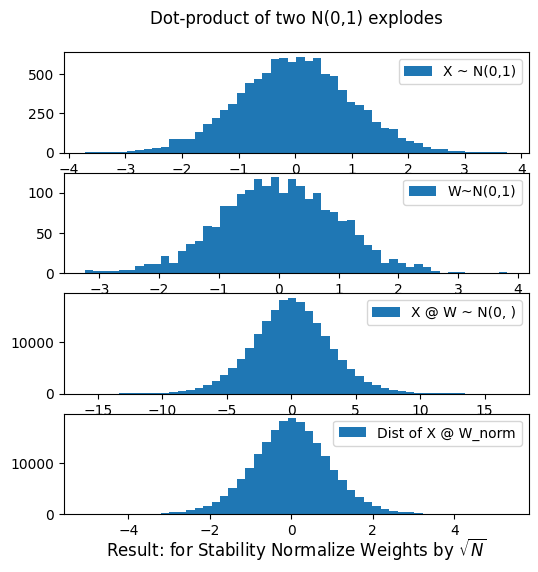

In [10]:
# Consider other example:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
w_norm = w / 10**0.5
y = x @ w

plt.figure(figsize=(6,6))
plt.subplot(411)
plt.hist(x.view(-1).tolist(), 50, label='X ~ N(0,1)');plt.legend()
plt.title('Dot-product of two N(0,1) explodes', y=1.2)
plt.subplot(412)
plt.hist(w.view(-1).tolist(), 50, label='W~N(0,1)');plt.legend()
plt.subplot(413)
plt.hist(y.view(-1).tolist(), 50, label='X @ W ~ N(0, )');plt.legend()

y_norm = x @ w_norm
plt.subplot(414)
plt.hist(y_norm.view(-1).tolist(), 50, label='Dist of X @ W_norm')
plt.legend()
plt.title('Result: for Stability Normalize Weights by $\\sqrt{N}$', y=-.5)

In [11]:
# compute loss score
@torch.no_grad()
def get_loss(split):
    assert split in ['train', 'dev', 'test'], f'{split} not yet supported'
    x,y = {
        'train' : (X_train, y_train),
        'dev'   : (X_dev, y_dev),
        'test'  : (X_test, y_test)
    }[split]

    emb = C[x]
    emb = emb.view(-1, WINDOW * EMB_SIZE)
    if BATCH_NORM:
        z = bn_gain * (emb @ hidden_W  - bn_mean) / bn_std + bn_bias
    else:
        z = emb @ hidden_W  + hidden_b
    h = torch.tanh(z)
    logits = h @ out_W + out_b
    loss = F.cross_entropy(logits, y)
    print(f'{split}{loss.item()=}')


get_loss('train')
get_loss('test')

# original train (2.12) dev (2.16)
# fix over-softmax train (2.07) dev (2.13)
# fix saturated tanh train (2.037) dev (2.106)
# add Batch Norm train (2.06) dev (2.109)

trainloss.item()=2.037429094314575
testloss.item()=2.1082441806793213


In [141]:
# Sample

for _ in range(20):

    out = []
    context = [0] * WINDOW
    while True:
        emb = C[torch.tensor(context)]
        emb = emb.view(1, -1)
        if BATCH_NORM:
            z = bn_gain * (emb @ hidden_W - bn_mean) / bn_std + bn_bias
        else:
            z = emb @ hidden_W + hidden_b
        h = torch.tanh(z)
        logits = h @ out_W + out_b
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

joyal.
der.
keyler.
aavi.
chatte.
fadalexya.
kheiliz.
ryd.
aisley.
ele.
baston.
osin.
korregg.
kob.
itzarm.
ebell.
rafi.
madaycin.
rajdiah.
saidenotukvla.


## Extra notes

### BatchNorm - helps stabilize the training of Deep NN
- for the first epoch, hidden sum func (aka z) is exactly ~ N(0,1). Then we learn gain*N(0,1) + bias

- mathematically, update of one particular neuron depends on other neurons in the given batch

    it creates leakage of gradient to other neurons due to substract & divide from normalization :(

- in PyTorch, torch.nn.BatchNorm1d internally keeps track of "running" mean and std, so don't forget to model.eva() during inference.

- for Linear layer (z = emb @ W + b), bias (b) becomes useless as we normalize (z) afterwards. So drop it off from architecture. **bn bias** replaces it